In [1]:
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import CocoDetection

import utils
from coco_utils import get_city
import transforms

# Load a model pre-trained on COCO and put it in inference mode

print('Loading pretrained model...')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Load the COCO 2017 train and val sets. We use the CocoDetection class definition
# from ./coco_utils.py, not the original torchvision.CocoDetection class. Also, we
# use transforms from ./transforms, not torchvision.transforms, because they need
# to transform the bboxes and masks along with the image.

# coco_path = "./COCO"

preprocess = transforms.Compose([
    transforms.ToTensor()
])
print('Loading COCO train, val datasets...')
coco_train_dataset = get_city('train',preprocess)
coco_val_dataset = get_city('val',preprocess)

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(coco_train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(coco_val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_fn)

Loading pretrained model...
Loading COCO train, val datasets...
loading annotations into memory...
Done (t=7.72s)
creating index...
index created!
loading annotations into memory...
Done (t=1.29s)
creating index...
index created!


In [2]:
from get_free_gpu import get_free_gpu

device = get_free_gpu()


print(device)
model.to(device)

cuda:0


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [3]:
# images, targets = next(iter(train_dataloader))

# # print(type(images), len(images))
# # print(images[0].shape)
# print(type(targets), len(targets))
# print(targets[0].keys())
# # # print()
# # # images = images.to(device)

# # import numpy as np
# images = [img.to(device) for img in images]
# print(len(images))
# # images.to(device)
# predictions = model(images)

# print('Prediction keys:', list(dict(predictions[0])))
# print('Boxes shape:', predictions[0]['boxes'].shape)
# print('Labels shape:', predictions[0]['labels'].shape)
# print('Scores shape:', predictions[0]['scores'].shape)
# print('Masks shape:', predictions[0]['masks'].shape)

In [3]:
import numpy as np
import cv2
import random

# Array of labels for COCO dataset (91 elements)

coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Random colors to use for labeling objects

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3)).astype(np.uint8)

# Overlay masks, bounding boxes, and labels on input numpy image

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # convert from RGB to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        mask = masks[i,:,:]
        red_map = np.zeros_like(mask).astype(np.uint8)
        green_map = np.zeros_like(mask).astype(np.uint8)
        blue_map = np.zeros_like(mask).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[mask > 0.5] = color[0]
        green_map[mask > 0.5] = color[1]
        blue_map[mask > 0.5] = color[2]
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        # apply colored mask to the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)
        # draw the bounding box around each object
        p1 = (int(boxes[i][0]), int(boxes[i][1]))
        p2 = (int(boxes[i][2]), int(boxes[i][3]))
        color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, p1, p2, color, 2)
        # put the label text above the objects
        p = (int(boxes[i][0]), int(boxes[i][1]-10))
        cv2.putText(image, labels[i], p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay masks, bounding boxes, and labels of objects with scores greater than
# threshold on one of the images in the input tensor using the predictions output by Mask R-CNN.

def prediction_to_mask_image(images, predictions, img_index, threshold):
    scores = predictions[img_index]['scores']
    boxes_to_use = scores >= threshold
    img = (images[img_index].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    masks = predictions[img_index]['masks'][boxes_to_use, :, :].cpu().detach().squeeze(1).numpy()
    boxes = predictions[img_index]['boxes'][boxes_to_use, :].cpu().detach().numpy()
    labels = predictions[img_index]['labels'][boxes_to_use].cpu().numpy()
    labels = [ coco_names[l] for l in labels ]

    return draw_segmentation_map(img, masks, boxes, labels)

# Train

In [5]:
from engine import train_one_epoch, evaluate
import utils

# Training
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

num_epochs = 10

for epoch in range(num_epochs):
    
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    lr_scheduler.step()
    
    torch.save(model.state_dict(), f"maskrcnn_finetune_city_epoch{epoch}" + ".pth")
    
    evaluate(model, val_dataloader, device=device)

# for images, targets in train_dataloader:
#     images = list(image.to(device) for image in images)
#     targets = [{k: v for k, v in t.items()} for t in targets]
#     output = model(images,targets)   # Returns losses and detections
#     print(output)
#     break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [  0/742]  eta: 0:49:05  lr: 0.000012  loss: 1.5441 (1.5441)  loss_classifier: 0.4814 (0.4814)  loss_box_reg: 0.4544 (0.4544)  loss_mask: 0.3625 (0.3625)  loss_objectness: 0.0650 (0.0650)  loss_rpn_box_reg: 0.1808 (0.1808)  time: 3.9703  data: 2.3399  max mem: 4995
Epoch: [0]  [ 10/742]  eta: 0:21:06  lr: 0.000079  loss: 1.5736 (1.5905)  loss_classifier: 0.4814 (0.4953)  loss_box_reg: 0.3783 (0.3592)  loss_mask: 0.3588 (0.3424)  loss_objectness: 0.1151 (0.1427)  loss_rpn_box_reg: 0.2095 (0.2509)  time: 1.7308  data: 1.0711  max mem: 5457
Epoch: [0]  [ 20/742]  eta: 0:20:01  lr: 0.000147  loss: 1.5908 (1.6035)  loss_classifier: 0.4509 (0.4923)  loss_box_reg: 0.3863 (0.3841)  loss_mask: 0.3903 (0.3663)  loss_objectness: 0.0936 (0.1305)  loss_rpn_box_reg: 0.1929 (0.2303)  time: 1.5494  data: 0.9798  max mem: 5457
Epoch: [0]  [ 30/742]  eta: 0:19:21  lr: 0.000214  loss: 1.4592 (1.5360)  loss_classifier: 0.3708 (0.4552)  loss_box_reg: 0.3837 (0.3733)  loss_mask: 0.3686 (0.3608) 

# Inference

In [6]:
from matplotlib import pyplot as plt

model.eval()
model.load_state_dict(torch.load('maskrcnn_finetune_city_epoch9.pth'))

<All keys matched successfully>

In [7]:
images, targets = next(iter(val_dataloader))


images = [img.to(device) for img in images]
print(len(images))

predictions = model(images)

4


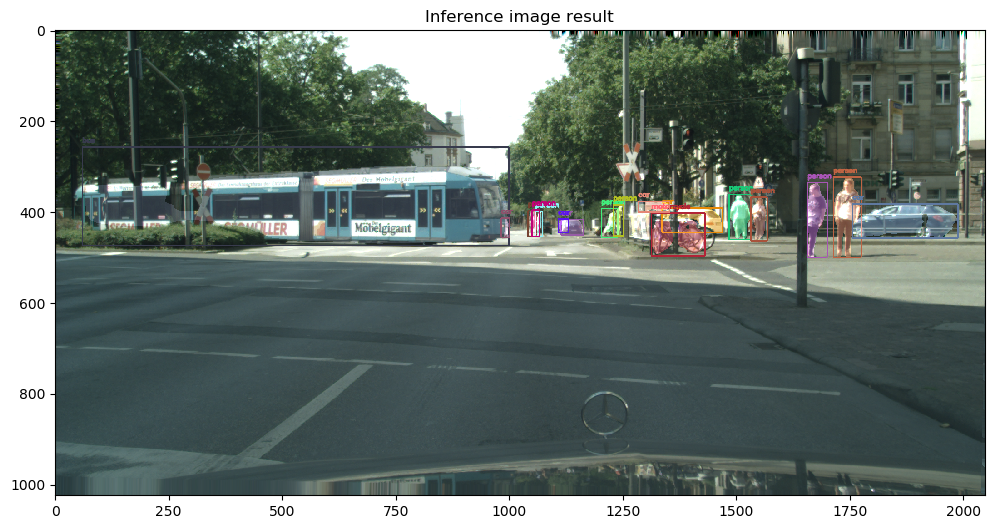

In [8]:
masked_img = prediction_to_mask_image(images, predictions, 0, 0.5)
plt.figure(1, figsize=(12, 9), dpi=100)
plt.imshow(masked_img)
plt.title('Inference image result')
plt.show()